# Import Library & Set Globals


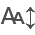

/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /opt/R/4.4.1/lib/R
INFO:rpy2.situation:R library path: /opt/R/4.4.1/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /opt/R/4.4.1/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no

In [ ]:
# base
import os
import sys
import warnings
import logging
logging.basicConfig(level='INFO')
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import scipy
import pandas as pd
import itables.options as opt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import decoupler as dc
import liana as li
from pacmap import LocalMAP

# custom
sys.path.append('../..')
from py import *

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from py.R import get_converter,R_preload
converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

In [4]:
%matplotlib inline
study = "paper_processed_FULL"
R_converted = False

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ['scDblFinder','DoubletFinder','doubletdetection','scrublet']

# Subclustering Prep

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
savedir = os.path.join(DATADIR,'processed',study,'py', '3_annotated')
adata = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))

# order categories
order_obs(adata, "Identifier", ['GSM7747185-LFD_eWAT','GSM7747187-HFD_eWAT','GSM7747186-LFD_iWAT','GSM7747188-HFD_iWAT'])
order_obs(adata, "Groups", ['GSM7747185-LFD_eWAT','GSM7747187-HFD_eWAT','GSM7747186-LFD_iWAT','GSM7747188-HFD_iWAT'])
order_obs(adata, "Experiment", ['GSM7747185', 'GSM7747186', 'GSM7747187', 'GSM7747188'])
order_obs(adata, "Condition", ['LFD', 'HFD'])
order_obs(adata, "Sample Type", ['eWAT', 'iWAT'])

In [ ]:
# # save
# annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
# savedir = os.path.join(DATADIR,'processed',study,'py', '3_annotated')
# adata.write(os.path.join(savedir,f'{annotation}.h5ad'))

# Fibroblasts

### Create Subset

In [ ]:
# subset
adata_fibros = adata[adata.obs["cell_type"] == "Fibroblast"].copy()
del adata_fibros.uns, adata_fibros.varm, adata_fibros.obsp
sc.pp.filter_cells(adata_fibros, min_genes=200)
sc.pp.filter_genes(adata_fibros, min_cells=5)
Visualize(adata_fibros,"_fibro")

In [ ]:
# integration check
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata_fibros, "Groups", f, embeddings=["UMAP_fibro", "LocalMAP_fibro"], nrow=2, ncol=2)

### Clusters

In [ ]:
recluster = False
key = "leiden_fibro"

if recluster is True:
    sc.tl.leiden(adata_fibros, resolution=0.5, key_added=key)
    # order_obs(adata_fibros,"leiden_fibro",pd.Series([2,1,6,0,4,3,7,5]).astype(str))

# figure prep
cluster_c = color_gen(adata_fibros.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_fibro" # "UMAP_fibro" # "LocalMAP_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
plot_violinplot(adata_fibros, markers, key, sf[1])

In [ ]:
# cluster composition
f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_fibros, "leiden_fibro", "Groups", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_fibros, "leiden_fibro", "Groups", pct=True, ax=axs[1])

pd.crosstab(adata_fibros.obs["leiden_fibro"],adata_fibros.obs["Groups"])

In [ ]:
# original subclusters
clear_uns(adata_fibros,'leiden_fibro')
sc.tl.rank_genes_groups(adata_fibros, groupby='leiden_fibro', key_added="de_fibro_sub",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_fibros, groupby="leiden_fibro", key='de_fibro_sub',
    standard_scale="var", n_genes=20, min_logfoldchange=2, ax=ax
)
sc.pl.rank_genes_groups_heatmap(adata_fibros, key='de_fibro_sub', groupby=['leiden_fibro'], layer='normalized')

### Cluster Regrouping

In [ ]:
adata_fibros.obs["leiden_fibro_group"] = adata_fibros.obs["leiden_fibro"].map(
    {'1' : 1, '2' : 1,
     '0' : 2, '3' : 2,
     '4' : 3,
     '5' : 4,
     }).astype(str)

# reannotate
order_obs(adata_fibros, "leiden_fibro_group",
          pd.Series(np.sort(adata_fibros.obs["leiden_fibro_group"].unique())).astype(str))

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=True, ax=axs[1])

pd.crosstab(adata_fibros.obs["leiden_fibro_group"],adata_fibros.obs["Groups"])

In [ ]:
# grouped vs original subclusters
clear_uns(adata_fibros,'leiden_fibro_group')

# run DEGs
sc.tl.rank_genes_groups(adata_fibros, groupby='leiden_fibro_group', key_added="de_fibro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

# plot DEGs dotplot
f, ax = plt.subplots(1,1,figsize=(20,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_fibros, groupby="leiden_fibro_group", key='de_fibro',
    standard_scale="var", n_genes=20, min_logfoldchange=2, ax=ax
)

# plot DEGs heatmap
sc.pl.rank_genes_groups_heatmap(adata_fibros, key='de_macro', groupby=['leiden_fibro'], layer='normalized', n_genes=50)
sc.pl.rank_genes_groups_heatmap(adata_fibros, key='de_fibro', groupby=['leiden_fibro_group'], layer='normalized')

In [ ]:
# figure prep
key = "leiden_fibro_group"
cluster_c = color_gen(adata_fibros.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_fibro" # "UMAP_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
plot_violinplot(adata_fibros, markers, key, sf[1])

In [ ]:
# relevant subsets
ewat_fibros = adata_fibros[adata_fibros.obs['Sample Type'] == 'eWAT'].copy()
ewat_fibros = ewat_fibros[ewat_fibros.obs["leiden_fibro_group"] != '4'].copy()

lfd_ewat_fibros = ewat_fibros[ewat_fibros.obs["Condition"] == 'LFD'].copy()
hfd_ewat_fibros = ewat_fibros[ewat_fibros.obs["Condition"] == 'HFD'].copy()

### Dissecting clusters

In [ ]:
# define markers
selected_markers = [
    "Pdgfra",
    "Ifitm3",      # Interferon-induced transmembrane protein 3, involved in antiviral defense and upregulated in inflamed/adipose tissues during obesity.
    "S100a4",      # S100 calcium-binding protein A4, marker of fibroblast subtypes, contributes to ECM remodeling and fibrosis in adipose tissue.
    "Il1rl2",      # Interleukin 1 receptor-like 2 (IL-36R), receptor for inflammatory cytokines with emerging roles in adipose fibroblast function.
    "Pi16",        # Peptidase inhibitor 16, marker for fibroblast heterogeneity and progenitor maintenance in adipose tissue.
    "Dlk1",        # Preadipocyte factor 1 (Dlk1), inhibits adipogenesis and maintains preadipocyte populations.
    "Fabp4",       # Fatty acid binding protein 4, involved in lipid metabolism, adipocyte function, and a key adipogenesis regulator.
    "Aqp1",        # Aquaporin 1, water channel expressed in various stromal and vascular cells, supports dynamic adipose tissue remodeling.
    "Dpp4",        # Dipeptidyl peptidase-4 (CD26), adipokine and fibroblast marker, regulates inflammation and is elevated in obesity.
    "Cd55",        # CD55 molecule, regulates complement activation and modulates local inflammation in adipose tissue.
    "F3",          # Coagulation factor III (tissue factor), pro-coagulant expressed by activated fibroblasts in inflamed or fibrotic adipose tissue.
    "Lpl",         # Lipoprotein lipase, essential for triglyceride metabolism and storage during adipose tissue expansion.
    "Cxcl12",      # Chemokine that regulates immune cell migration; may influence macrophage recruitment, immune modulation, and tissue remodeling in adipose tissue fibroblasts.
    "Cthrc1",      # Marker of activated fibroblasts; involved in ECM remodeling and fibrosis, potentially contributing to fibrotic responses in adipose tissue.
    "Postn",       # Encodes periostin, a key marker of activated fibroblasts that regulates extracellular matrix composition and fibrosis in response to tissue stress or injury.
    "Saa3",        # Acute phase protein upregulated during inflammation; involved in local tissue immune responses and inflammatory signaling in adipose tissue.
    "Lcn2",        # Adipokine involved in regulating inflammation and metabolic homeostasis; alleviates adipose tissue inflammation and modulates metabolic gene expression.
    "Scube2",      # Cell surface protein that acts in Sonic Hedgehog signaling and potentially ECM regulation; direct relevance in adipose fibroblasts is less established.
    "Npnt",        # Encodes nephronectin, an extracellular matrix protein possibly involved in cell adhesion and tissue organization; specifics for adipose fibroblasts are not well established.
    "Ces1d",       # Carboxylesterase involved in triglyceride hydrolysis and lipid mobilization in adipose tissue, important for adipocyte lipid metabolism and energy balance.
    "Wnt2",        # Secreted ligand in the WNT signaling pathway; may influence fibroblast activation and adipogenesis through paracrine signaling in adipose tissue.
    "Cxcl13",
]

tgfb_genes = [
    "Il33","Ly6a", "Ccl2", "Dpp4",                                  # No response
    "Smad2", "Smad3", "Smad4", "Serpine1", "Id1", "Id2", "Id3",     # Intermediate responsive
    "Fn1", "Postn", "Cthrc1", "Vim", "Col1a1", "Col1a2", "Serpinh1" # High responsive
]

ifn_genes = [
    "Fasn", "Irs1", "Insr",                                         # Repressed
    "Irf3", "Irf4", "Ifi47", "Irf1", "Ifitm1", "Ifitm2", "Ifitm3"   # Induced
]

all_fibro_markers = pd.Series(selected_markers + tgfb_genes + ifn_genes).unique().tolist()

In [ ]:
# All FBs
pop_name = "All FBs"

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(adata_fibros,"Condition","leiden_fibro_group", selected_markers, f)
f.suptitle(f"HFD vs LFD expression by cluster ({pop_name})\nSelected markers", fontsize=30)

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(adata_fibros,"Condition","leiden_fibro_group", tgfb_genes, f)
f.suptitle(f"HFD vs LFD expression by cluster {pop_name})\nCurated TGFβ-responsive genes", fontsize=30)

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(adata_fibros,"Condition","leiden_fibro_group", ifn_genes, f)
f.suptitle(f"HFD vs LFD expression by cluster ({pop_name})\nCurated IFN-responsive genes", fontsize=30)

# f = plt.figure(figsize=(6,15),layout="constrained")
# sf = f.subfigures(1,2)
# plot_violinplot(adata_fibros, markers, "Condition", sf[0], useStripPlot=False)
# plot_violinplot(adata_fibros, markers, "leiden_fibro_group", sf[1], useStripPlot=False)
# f.suptitle('Selected marker expression by Condition & Clusters (All FBs)', fontsize=15)

# axs = sc.pl.embedding(adata_fibros, basis="LocalMAP_fibro", layer='normalized', color=all_fibro_markers+["leiden_fibro", "leiden_fibro_group", "Condition"],
#                       ncols=5, alpha=0.7, show=False)
# f = axs[0].get_figure()
# f.suptitle('Feature plots for all markers (All FBs)', fontsize=30)

In [ ]:
axs = sc.pl.embedding(ewat_fibros, basis="UMAP_fibro", layer='normalized', color=["Cthrc1"]+["leiden_fibro", "leiden_fibro_group", "Condition"],
                      ncols=5, alpha=0.7, show=False, cmap="BuPu")

In [ ]:
# eWAT FBs
pop_name = "eWAT FBs"
ewat_fibros = adata_fibros[adata_fibros.obs['Sample Type'] == 'eWAT'].copy()
ewat_fibros = ewat_fibros[ewat_fibros.obs["leiden_fibro_group"] != '4'].copy()

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(ewat_fibros,"Condition","leiden_fibro_group", selected_markers, f)
f.suptitle(f"HFD vs LFD expression by cluster ({pop_name})\nSelected markers", fontsize=30)

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(ewat_fibros,"Condition","leiden_fibro_group", tgfb_genes, f)
f.suptitle(f"HFD vs LFD expression by cluster ({pop_name})\nCurated TGFβ-responsive genes", fontsize=30)

f = plt.figure(figsize=(20,20),layout="constrained")
plot_cluster_violinplot(ewat_fibros,"Condition","leiden_fibro_group", ifn_genes, f)
f.suptitle(f"HFD vs LFD expression by cluster ({pop_name})\nCurated IFN-responsive genes", fontsize=30)

axs = sc.pl.embedding(ewat_fibros, basis="LocalMAP_fibro", layer='normalized', color=all_fibro_markers+["leiden_fibro", "leiden_fibro_group", "Condition"],
                      ncols=5, alpha=0.7, show=False)
f = axs[0].get_figure()
f.suptitle('Feature plots for all markers (All FBs)', fontsize=30)

# ewat_fibros.obs["Condition-Cluster"] = (ewat_fibros.obs["Condition"].astype(str) + "-Cluster_" + ewat_fibros.obs["leiden_fibro_group"].astype(str)).astype("category")
# order_obs(ewat_fibros, "Condition-Cluster",['LFD-Cluster_1', 'LFD-Cluster_2', 'LFD-Cluster_3',
#                                             'HFD-Cluster_1', 'HFD-Cluster_2', 'HFD-Cluster_3'])

# f = plt.figure(figsize=(10,15),layout="constrained")
# plot_violinplot(ewat_fibros, tgfb_genes, "Condition-Cluster", f, bracket_params={"ratio" : [1,1],
#                                                                                    "labels" : ["LFD", "HFD"],
#                                                                                    "bracket_y" : 0.4,
#                                                                                    "label_y" : 0.65,
#                                                                                    "padding" : 35})
# f.suptitle("HFD vs LFD expression by cluster (TGFβ-response genes)", fontsize=15)

# f = plt.figure(figsize=(10,15),layout="constrained")
# plot_violinplot(ewat_fibros, ifn_genes, "Condition-Cluster", f, bracket_params={"ratio" : [1,1],
#                                                                                    "labels" : ["LFD", "HFD"],
#                                                                                    "bracket_y" : 0.4,
#                                                                                    "label_y" : 0.65,
#                                                                                    "padding" : 35})
# f.suptitle("HFD vs LFD expression by cluster (IFN-response genes)", fontsize=15)

# f = plt.figure(figsize=(10,18),layout="constrained")
# plot_violinplot(ewat_fibros, markers, "Condition-Cluster", f, bracket_params={"ratio" : [1,1],
#                                                                                    "labels" : ["LFD", "HFD"],
#                                                                                    "bracket_y" : 0.4,
#                                                                                    "label_y" : 0.65,
#                                                                                    "padding" : 35})
# f.suptitle("HFD vs LFD expression by cluster (FB classification genes)", fontsize=15)

In [ ]:
features_plot = ["Ifitm3", "Ly6a", "Id2", "Id3", "Fn1", "Postn", "Serpinh1", "Cxcl12"]
axs = sc.pl.embedding(ewat_fibros, basis="LocalMAP_fibro", layer='normalized', color=features_plot+["leiden_fibro", "leiden_fibro_group", "Condition"],
                      ncols=5, alpha=0.7, show=False)

In [ ]:
sc.pl.embedding(lfd_ewat_fibros, basis="LocalMAP_fibro", layer='normalized', color=features_plot+["leiden_fibro_group", "Condition"],
                ncols=4, alpha=0.7)
sc.pl.embedding(hfd_ewat_fibros, basis="LocalMAP_fibro", layer='normalized', color=features_plot+["leiden_fibro_group", "Condition"],
                ncols=4, alpha=0.7)

In [ ]:
# original subclusters
clear_uns(ewat_fibros,'leiden_fibro_group')
sc.tl.rank_genes_groups(ewat_fibros, groupby='leiden_fibro_group', key_added="de_fibro_ewat_clusters",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    ewat_fibros, groupby="leiden_fibro_group", key='de_fibro_ewat_clusters',
    standard_scale="var", n_genes=40, min_logfoldchange=2, ax=ax
)

### ORA Enrichment

In [ ]:
sources = ['GO:MF', 'GO:CC', 'KEGG', 'REAC']

GOterms = GO_Enrich(adata_fibros, "leiden_fibro_group", "de_fibro", sources=sources, pval_cutoff=1e-5, log2fc_min=1)

figsizes = [(8,12), (8,14), (8,8), (8,10)]
for n,source in enumerate(sources):
    fig = plot_go_enrichment(
        df_dict=GOterms[source],
        pvalue_col='p_value',
        score_col='term_size',
        pvalue_threshold=0.05,
        rank_by='pvalue',
        top_n=15,
        use_log_pvalue=True,
        use_log_score=False,
        figsize=figsizes[n],
        database=source
    )

    plt.show()

### GSEA

In [ ]:
name = "FIBRO_MSigDB-MH"
GSEA_decoupler(adata_fibros, name, geneset_dir=os.path.join(ref_dir,"mh.all.v2025.1.Mm.symbols.gmt"))

fig, ax = plot_go_enrichment(
    df_dict=GOterms["KEGG"],
    pvalue_col='p_value',
    score_col='term_size',
    pvalue_threshold=0.05,
    use_log_pvalue=True,
    use_log_score=False,
    figsize=(8,5)
)

# plot_gsea(adata_fibros, f"GSEA ({name})", f"{name}_score_ulm", 'fibro_leiden_group', 5, name)

In [ ]:
run_GSEA = True

# get geneset info
ref_dir = os.path.join(REFDIR,"interactome")
gsea_sets = {
    "FIBRO_MSigDB-MH" : os.path.join(ref_dir,"mh.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M2-CP" : os.path.join(ref_dir,"m2.cp.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M3" : os.path.join(ref_dir,"m3.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M5-GO" : os.path.join(ref_dir,"m5.go.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M7" : os.path.join(ref_dir,"m7.all.v2025.1.Mm.symbols.gmt"), 
    "FIBRO_MSigDB-M8" : os.path.join(ref_dir,"m8.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_CollecTRI" : dc.op.collectri(organism='mouse')
}

# run GSEA
if run_GSEA is True:
    for name, geneset in gsea_sets.items():
        if type(geneset) is str:
            GSEA_decoupler(adata_fibros, name, geneset_dir=geneset)
        else:
            GSEA_decoupler(adata_fibros, name, geneset=geneset)


# plot
f = plt.figure(figsize=(len(gsea_sets)*8,10), layout="constrained")
sf = f.subfigures(1,len(gsea_sets))
for name in gsea_sets.keys():
    plot_gsea(adata_fibros, f"GSEA ({name})", f"{name}_score_ulm", 'fibro_leiden_group', 5, name)

### Save/Load

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1-fibro_leiden_0.5"
savedir = os.path.join(DATADIR,'processed',study,'py','4_subclustered')
os.makedirs(savedir, exist_ok=True)
adata_fibros.write(os.path.join(savedir, f'{annotation}.h5ad'))

In [1]:
# load
annotation = "manDoublet-seuratV3-harmony-leiden_1-fibro_leiden_0.5"
savedir = os.path.join(DATADIR,'processed',study,'py','4_subclustered')
adata_fibros = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))

# relevant subsets
ewat_fibros = adata_fibros[adata_fibros.obs['Sample Type'] == 'eWAT'].copy()
ewat_fibros = ewat_fibros[ewat_fibros.obs["leiden_fibro_group"] != '4'].copy()

lfd_ewat_fibros = ewat_fibros[ewat_fibros.obs["Condition"] == 'LFD'].copy()
hfd_ewat_fibros = ewat_fibros[ewat_fibros.obs["Condition"] == 'HFD'].copy()

NameError: name 'os' is not defined

In [ ]:
# load
savedir = os.path.join(DATADIR,'processed',study,'py','3_annotated')
annotation = "manDoublet-seuratV3-harmony-leiden_1"
adata = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))


savedir = os.path.join(DATADIR,'processed',study,'py','4_subclustered')

annotation = "manDoublet-seuratV3-harmony-leiden_1-macro_leiden_0.5"
adata_macros = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))

annotation = "manDoublet-seuratV3-harmony-leiden_1-fibro_leiden_0.5"
adata_fibros = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))

### All Cells

In [ ]:
# ligand & receptor
cell2cell_interactions(adata, cores=CORES)
cell_interest = ["Fibroblast","Macrophage"]
plot_c2c(adata, "ccc_filtered", sources=cell_interest, targets=cell_interest,
              top_n=50, figsize=(15,10))

# Save as CSV
filtered = adata.uns["ccc_filtered"].copy()
filtered_macfib = filtered[filtered.source.isin(cell_interest) & filtered.target.isin(cell_interest)]
# filtered_macfib.to_csv("filtered_macro_fibro_interactions")

### Fibros & Macros

In [ ]:
ewat_macros = adata_macros[adata_macros.obs["Sample Type"].isin(["eWAT"])].copy()
ewat_fibros = adata_fibros[adata_fibros.obs["Sample Type"].isin(["eWAT"])].copy()
ewat_fms = sc.concat([ewat_fibros,ewat_macros], join='outer')

ewat_fms.raw = dc.pp.swap_layer(ewat_fms, "counts")
ewat_fms.obs['Subclusters'] = (pd.concat(['Fibroblast_' + ewat_fms.obs['leiden_fibro_group'].dropna().astype(str),
                                           'Macrophage_' + ewat_fms.obs['leiden_macro_group'].dropna().astype(str)])
                                .astype('category'))
cell2cell_interactions(ewat_fms, cell_group='Subclusters', key="ccc_FMs", cores=CORES)

# ewat_fms.uns["ccc_FMs_filtered"][['source', 'target', 'ligand_complex', 'receptor_complex', 'specificity_rank', 'magnitude_rank']]

In [ ]:
# dc.op.show_resources()
dc.op.resource("CellChatDB", 'mouse')

In [ ]:
plot_c2c(ewat_fms, "ccc_FMs_filtered", top_n=200,
         sources=[f"Fibroblast_{i}" for i in np.arange(4)+1],
         targets=["Macrophage_8"],
         figsize=(10,20))

In [ ]:
plot_c2c(ewat_fms, "ccc_FMs_filtered", top_n=200,
         sources=[f"Fibroblast_{i}" for i in np.arange(4)+1],
         targets=[f"Macrophage_{i}" for i in np.arange(8)+1],
         figsize=(20,10))

plot_c2c(ewat_fms, "ccc_FMs_filtered", top_n=200,
         sources=["Macrophage_8"],
         targets=[f"Fibroblast_{i}" for i in np.arange(4)+1],
         figsize=(5,20))

### Save/Load

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1"
savedir = os.path.join(DATADIR,'processed',study,'py','3_annotated')
adata.write(os.path.join(savedir, f'{annotation}.h5ad'))

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1-fibros_macros"
savedir = os.path.join(DATADIR,'processed',study,'py','4_subclustered')
adata_fms.write(os.path.join(savedir, f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-leiden_1-fibros_macros"
savedir = os.path.join(DATADIR,'processed',study,'py','4_subclustered')
adata_fms = sc.read_h5ad(os.path.join(savedir, f'{annotation}.h5ad'))

# Cytokine Response Signatures

In [6]:
filename = os.path.join(REFDIR,"Carlos_DEseq2_data.xlsx")
exposures = pd.ExcelFile(filename).sheet_names
bulkseqs = [pd.read_excel(filename, sheet_name=sheet, usecols=np.arange(7), nrows=2000) for sheet in exposures]
bulkseqs[0][(bulkseqs[0]["P.adj"] > 1e-5) & (bulkseqs[0]["Log2.FC."] > 1)]

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [7]:
pval_cutoff = 1e-5
log2fc_cutoff = 1

up_signatures = dict(zip([f"{i}_UP" for i in exposures],
                         [data[(data["P.adj"] < pval_cutoff) & (data["Log2.FC."] > log2fc_cutoff)] for data in bulkseqs]))
dn_signatures = dict(zip([f"{i}_DOWN" for i in exposures],
                         [data[(data["P.adj"] < pval_cutoff) & (data["Log2.FC."] < -log2fc_cutoff)] for data in bulkseqs]))
signatures = up_signatures | dn_signatures

pd.DataFrame([(i[0], i[1].shape[0]) for i in signatures.items()])

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


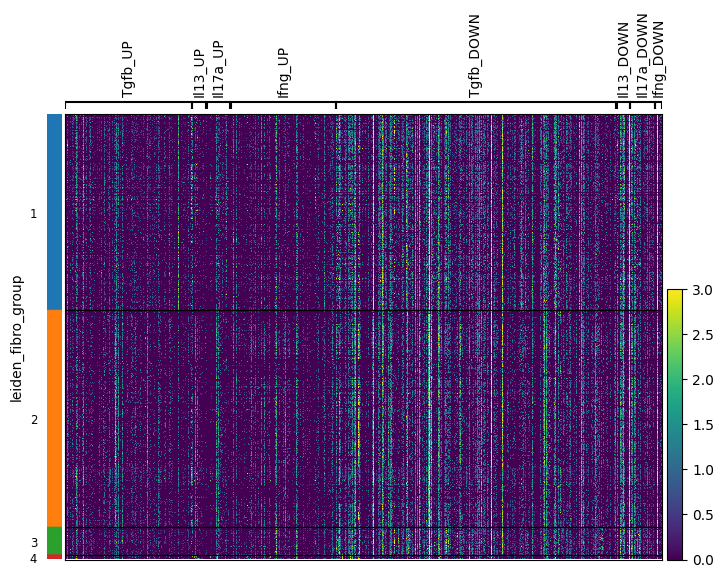

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [8]:
groups = [name for name in signatures.keys()]
ends = [0]
brackets = []
gene_names = []
for key,sig in signatures.items():
    sig_genes = sig.iloc[:,0]
    sig_genes = sig_genes[sig_genes.isin(adata_fibros.var_names)]

    ends.append(len(sig_genes))
    gene_names.append(sig_genes)

brackets = [(np.cumsum(ends)[i], np.cumsum(ends)[i+1])for i in range(len(ends)-1)]
gene_names = pd.concat(gene_names)
sc.pl.heatmap(adata_fibros, gene_names, groupby='leiden_fibro_group', var_group_positions=brackets, var_group_labels=groups,
              layer='normalized', use_raw=False, vmax=3)

adata_fibros[:,gene_names].var.nlargest(10, 'means')

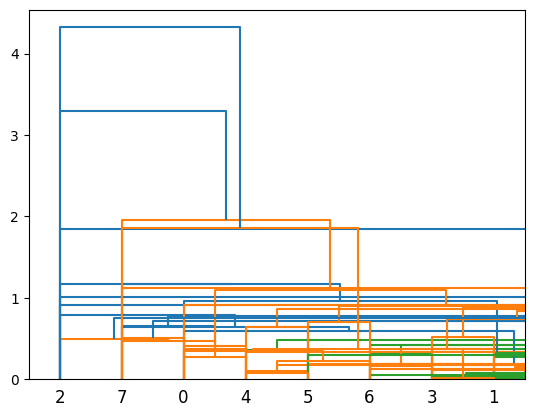

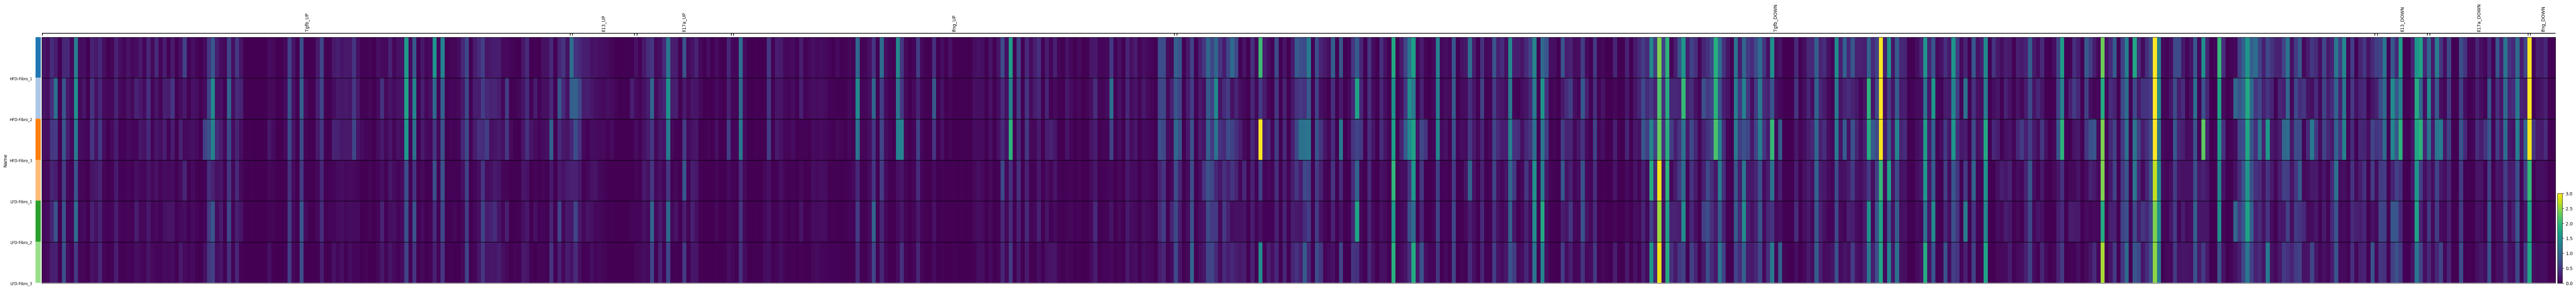

In [ ]:
from scipy.sparse._csr import csr_matrix

ewat_fibros.obs["Condition-Cluster"] = (ewat_fibros.obs["Condition"].astype(str) + "-Fibro_" + ewat_fibros.obs["leiden_fibro_group"].astype(str)).astype("category")

def find_var_means(adata, groupby, layer="normalized"):
    arr = adata.layers[layer]
    if type(arr) is csr_matrix:
        arr = arr.toarray()

    tmp = pd.concat((pd.DataFrame(arr, columns=adata.var_names).reset_index(drop=True),
                     adata.obs[groupby].reset_index(drop=True)),
                    axis=1)

    dfs = [(name,np.mean(df.iloc[:,:-1], axis=0)) for name,df in tmp.groupby(groupby)]
    tmp = pd.concat([df[1] for df in dfs], axis=1)
    tmp.columns = [df[0] for df in dfs]
    return tmp

means = find_var_means(ewat_fibros,"Condition-Cluster")

tmp_adata = sc.AnnData(X=means.loc[gene_names.unique()].T)
tmp_adata.obs["Name"] = tmp_adata.obs_names

boundaries = [0]
gene_names_ordered = []
brackets = []
for name,sig in signatures.items():
    genes = sig.iloc[:,0][sig.iloc[:,0].isin(tmp_adata.var_names)]
    order = scipy.cluster.hierarchy.linkage(tmp_adata[:,genes].X.T,optimal_ordering=True)
    order = scipy.cluster.hierarchy.dendrogram(order)['leaves']
    genes_to_plot = sig.iloc[order].iloc[:,0]
    genes_to_plot = genes_to_plot[genes_to_plot.isin(tmp_adata.var_names)]
    gene_names_ordered += genes_to_plot.tolist()
    boundaries.append(len(gene_names_ordered))
    brackets.append((boundaries[-2],boundaries[-1]))

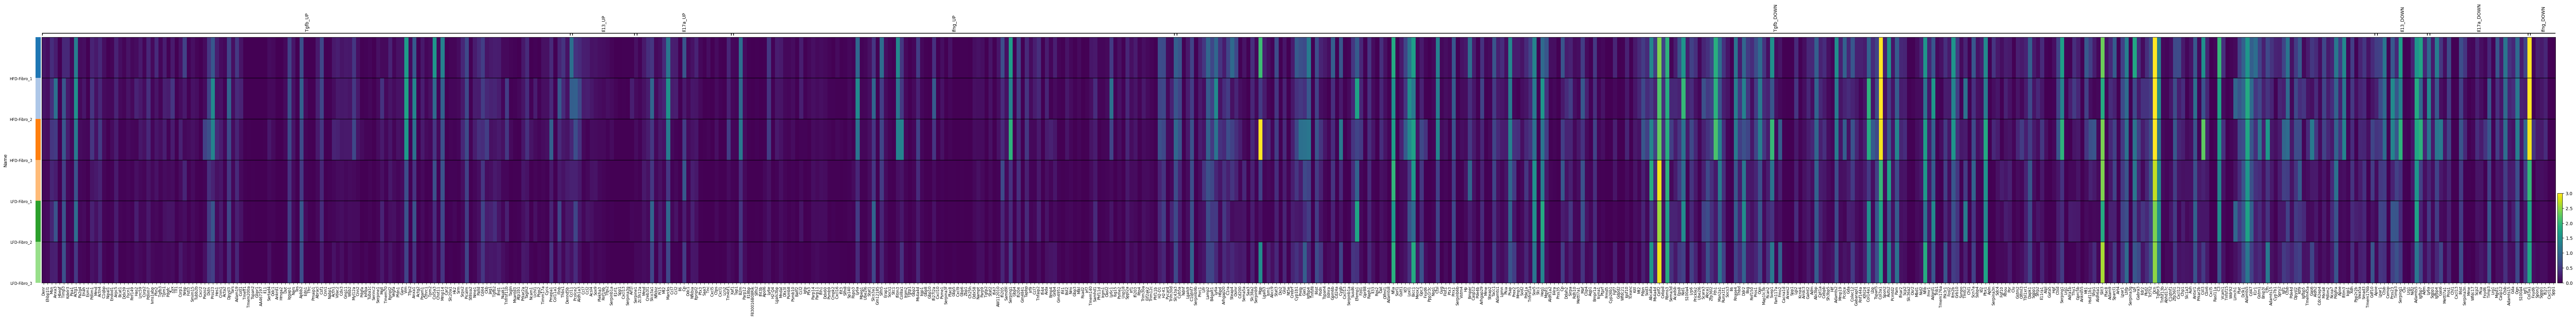

In [110]:
ax = sc.pl.heatmap(tmp_adata, gene_names_ordered, groupby="Name", var_group_positions=brackets, var_group_labels=groups, vmax=3,
                   figsize=(100,10),show_gene_labels=True)

In [ ]:
def GSEA_decoupler(
    adata,
    name: str,
    type: str = "ULM",
    geneset_dir: str = None,
    geneset=None,
):
    if geneset is None:
        assert geneset_dir is not None
        geneset = dc.pp.read_gmt(geneset_dir)

    if type == "ULM":
        dc.mt.ulm(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
        adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
        del adata.obsm["score_ulm"], adata.obsm["padj_ulm"]

    elif type == "GSEA":
        dc.mt.gsea(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_gsea"] = adata.obsm["score_gsea"]
        adata.obsm[f"{name}_padj_gsea"] = adata.obsm["padj_gsea"]
        del adata.obsm["score_gsea"], adata.obsm["padj_gsea"]

    elif type == "AUCell":
        dc.mt.aucell(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_aucell"] = adata.obsm["score_aucell"]
        del adata.obsm["score_aucell"]

    return adata

curated_geneset = []
for name,genes in signatures.items():
    df = genes.copy()
    df["target"] = df["Unnamed: 0"]
    df["source"] = name
    curated_geneset.append(df[["source","target"]])

curated_geneset = pd.concat(curated_geneset)

name = "Cytokine Response (Carlos DESeq)"
GSEA_decoupler(ewat_fibros, name, geneset=curated_geneset)
GSEA_decoupler(ewat_fibros, name, geneset=curated_geneset, type="AUCell")

In [ ]:
# adata_fibros.obs["Condition-Cluster"] = (adata_fibros.obs["Condition"].astype(str) + "-Fibro_" + adata_fibros.obs["leiden_fibro_group"].astype(str)).astype('category')

score_obj = dc.pp.get_obsm(adata=ewat_fibros, key=f"{name}_score_ulm")
tmp = pd.concat((pd.DataFrame(score_obj.X, columns=score_obj.var_names).reset_index(drop=True),
                 score_obj.obs["Condition-Cluster"].reset_index(drop=True)),
                axis=1)

dfs = [(name,np.mean(df.iloc[:,:-1], axis=0)) for name,df in tmp.groupby("Condition-Cluster")]
tmp = pd.concat([df[1] for df in dfs], axis=1)
tmp.columns = [df[0] for df in dfs]
cs = len(score_obj.obs["Condition-Cluster"].cat.categories)//2

diff = pd.DataFrame(tmp.iloc[:,:cs].values - tmp.iloc[:,cs:].values,
             columns=tmp.columns[:cs].str.replace("HFD-",""),
             index=tmp.index)
sns.heatmap(diff, annot=True)
plt.title("diff in means btwn HFD - LFD enrichment")

In [ ]:
def plot_gsea(adata, name, key="score_ulm", group="cell_type", n_markers=5, flip=True):
    score = dc.pp.get_obsm(adata=adata, key=key)
    df = dc.tl.rankby_group(
        adata=score, groupby=group, reference="rest", method="wilcoxon"
    )
    df = df[df["stat"] > 0]

    source_markers = (
        df.groupby("group")
        .head(n_markers)
        .drop_duplicates("name")
        .groupby("group")["name"]
        .apply(lambda x: list(x))
        .to_dict()
    )

    del score.uns

    sc.pl.matrixplot(
        adata=score,
        var_names=source_markers,
        groupby=group,
        dendrogram=False,
        # standard_scale="var",
        # colorbar_title="Z-scaled scores",
        cmap="Reds",
        swap_axes=flip,
        title=name,
    )

    return score

ulm_score = plot_gsea(ewat_fibros, f"GSEA ({name} - ULM model)", f"{name}_score_ulm", 'Condition-Cluster', 10, name)
aucell_score = plot_gsea(ewat_fibros, f"GSEA ({name} - AUCell model)", f"{name}_score_aucell", 'Condition-Cluster', 10, name)